In [ ]:
!pip install zarr

In [ ]:
!pip install xarray[complete]

In [3]:
pip install cftime

In [ ]:
!pip install chex dm-haiku jax jaxlib jraph optax orbax xarray netcdf4

In [5]:
import gcsfs
import xarray as xr
import cftime
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from datetime import timedelta

In [6]:
fs = gcsfs.GCSFileSystem(token='anon', access='read_only')

In [7]:
# all gn grid

# - - - - - surface variables - - - - -
# surface temp
tas = fs.get_mapper("cmip6/CMIP6/CMIP/MOHC/HadGEM3-GC31-LL/historical/r1i1p1f3/day/tas/gn/v20190624")
# u wind component
uas = fs.get_mapper("cmip6/CMIP6/CMIP/MOHC/HadGEM3-GC31-LL/historical/r1i1p1f3/day/uas/gn/v20190624")
# v wind component
vas = fs.get_mapper("cmip6/CMIP6/CMIP/MOHC/HadGEM3-GC31-LL/historical/r1i1p1f3/day/vas/gn/v20190624")
# mean sea level pressure
psl = fs.get_mapper("cmip6/CMIP6/CMIP/MOHC/HadGEM3-GC31-LL/historical/r1i1p1f3/day/psl/gn/v20190624")
# total precip
pr = fs.get_mapper("cmip6/CMIP6/CMIP/MOHC/HadGEM3-GC31-LL/historical/r1i1p1f3/day/pr/gn/v20190624")

# - - - atmospheric variables - - -
# vertical temp
ta = fs.get_mapper("cmip6/CMIP6/CMIP/MOHC/HadGEM3-GC31-LL/historical/r1i1p1f3/6hrLev/ta/gn/v20200823")
# u wind component
ua = fs.get_mapper("cmip6/CMIP6/CMIP/MOHC/HadGEM3-GC31-LL/historical/r1i1p1f3/6hrLev/ua/gn/v20200823")
# v wind component
va = fs.get_mapper("cmip6/CMIP6/CMIP/MOHC/HadGEM3-GC31-LL/historical/r1i1p1f3/6hrLev/va/gn/v20200823")
# geopotential (geo height * grav)
zg = fs.get_mapper("cmip6/CMIP6/CMIP/MOHC/HadGEM3-GC31-LL/historical/r1i1p1f3/day/zg/gn/v20190624")
# specific humidity
hus = fs.get_mapper("cmip6/CMIP6/CMIP/MOHC/HadGEM3-GC31-LL/historical/r1i1p1f3/6hrLev/hus/gn/v20200902")
# vertical velocity
wap = fs.get_mapper("cmip6/CMIP6/CMIP/MOHC/HadGEM3-GC31-LL/historical/r1i1p1f3/day/wap/gn/v20190624")

# surface variables, zg & wap are daily
# all others are 6hrLev

In [8]:
tas_data = xr.open_zarr(tas, consolidated=True)
uas_data = xr.open_zarr(uas, consolidated=True)
vas_data = xr.open_zarr(vas, consolidated=True)
psl_data = xr.open_zarr(psl, consolidated=True)
pr_data = xr.open_zarr(pr, consolidated=True)
ta_data = xr.open_zarr(ta, consolidated=True)
ua_data = xr.open_zarr(ua, consolidated=True)
va_data = xr.open_zarr(va, consolidated=True)
zg_data = xr.open_zarr(zg, consolidated=True)
hus_data = xr.open_zarr(hus, consolidated=True)
wap_data = xr.open_zarr(wap, consolidated=True)

In [9]:
data = [tas_data , uas_data , vas_data , psl_data , pr_data , ta_data , ua_data ,
        va_data , zg_data , hus_data , wap_data]
print(len(data))
# slicing for one year - CMIP6 data retrieved is 1850-2014, but TRACK is 1979-2012 (?)
  # so using 2010 as safe measure for cyclones in 2011 and 2012
tas_data_2010 = tas_data.sel(time = (tas_data.time.dt.year == 2010))
uas_data_2010 = uas_data.sel(time = (uas_data.time.dt.year == 2010))
vas_data_2010 = vas_data.sel(time = (vas_data.time.dt.year == 2010))
psl_data_2010 = psl_data.sel(time = (psl_data.time.dt.year == 2010))
pr_data_2010  = pr_data.sel(time = (pr_data.time.dt.year == 2010))
ta_data_2010  = ta_data.sel(time = (ta_data.time.dt.year == 2010))
ua_data_2010  = ua_data.sel(time = (ua_data.time.dt.year == 2010))
va_data_2010  = va_data.sel(time = (va_data.time.dt.year == 2010))
zg_data_2010  = zg_data.sel(time = (zg_data.time.dt.year == 2010))
hus_data_2010 = hus_data.sel(time = (hus_data.time.dt.year == 2010))
wap_data_2010 = wap_data.sel(time = (wap_data.time.dt.year == 2010))

11


In [10]:
# upsampling daily to 6hr for graphcast
def upsample_to_fixed_6hr(ds):
    start = ds.time.values[0]
    end = ds.time.values[-1] + timedelta(hours=18)

    calendar = ds.time.encoding.get("calendar", "360_day")

    target_time = xr.date_range(start=start, end=end, freq="6h", calendar=calendar, use_cftime=True)

    ds_interp = ds.interp(time=target_time)

    assert ds_interp.sizes["time"] == 1440, f"Time mismatch: expected 1440, got {ds_interp.sizes['time']}"

    return ds_interp

tas_6hr = upsample_to_fixed_6hr(tas_data_2010)
uas_6hr = upsample_to_fixed_6hr(uas_data_2010)
vas_6hr = upsample_to_fixed_6hr(vas_data_2010)
psl_6hr = upsample_to_fixed_6hr(psl_data_2010)
pr_6hr  = upsample_to_fixed_6hr(pr_data_2010)
zg_6hr  = upsample_to_fixed_6hr(zg_data_2010)

In [11]:
tas_6hr

<xarray.Dataset> Size: 159MB
Dimensions:    (lat: 144, bnds: 2, lon: 192, time: 1440)
Coordinates:
    height     float64 8B ...
    lat        (lat) float64 1kB -89.38 -88.12 -86.88 ... 86.88 88.12 89.38
    lat_bnds   (lat, bnds) float64 2kB dask.array<chunksize=(144, 2), meta=np.ndarray>
    lon        (lon) float64 2kB 0.9375 2.812 4.688 6.562 ... 355.3 357.2 359.1
    lon_bnds   (lon, bnds) float64 3kB dask.array<chunksize=(192, 2), meta=np.ndarray>
  * time       (time) object 12kB 2010-01-01 12:00:00 ... 2011-01-01 06:00:00
    time_bnds  (time, bnds) object 23kB dask.array<chunksize=(360, 1), meta=np.ndarray>
Dimensions without coordinates: bnds
Data variables:
    tas        (time, lat, lon) float32 159MB dask.array<chunksize=(1440, 144, 192), meta=np.ndarray>
Attributes: (12/47)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    branch_method:          standard
    branch_time_in_child:   0.0
    branch_time_in_parent:  0.0
    cmor_version:           3.4.0
    ...                     ...
    table_info:             Creation Date:(13 December 2018) MD5:2b12b5db6db1...
    title:                  HadGEM3-GC31-LL output prepared for CMIP6
    tracking_id:            hdl:21.14100/2e2594b1-6c0f-445f-8d56-98010212540e...
    variable_id:            tas
    variant_label:          r1i1p1f3
    status:                 2019-11-16;created;by nhn2@columbia.edu

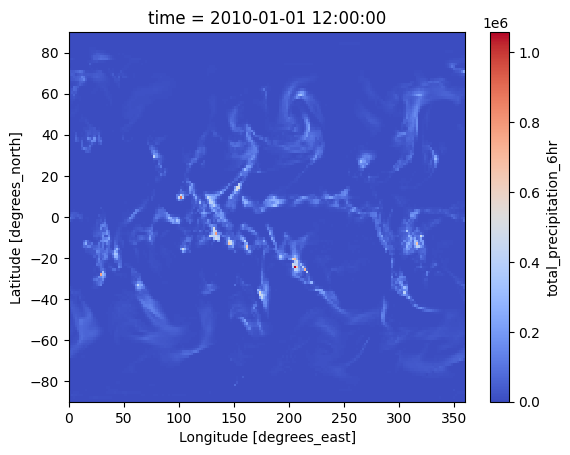

In [104]:
# converting pr (kg m-2 s-1) to 6hour total in mm (1 kg/m2 = 1mm)
pr_6hr["pr"] = pr_6hr["pr"] * 21600
pr_6hr_t = pr_6hr.rename({"pr": "total_precipitation_6hr"})
pr_6hr_t

pr_6hr_t['total_precipitation_6hr'].sel(time=cftime.Datetime360Day(2010, 1, 1, 12, 0, 0, 0)).plot(cmap = 'coolwarm')

In [13]:
zg_6hr

<xarray.Dataset> Size: 1GB
Dimensions:    (lat: 144, bnds: 2, lon: 192, plev: 8, time: 1440)
Coordinates:
    lat        (lat) float64 1kB -89.38 -88.12 -86.88 ... 86.88 88.12 89.38
    lat_bnds   (lat, bnds) float64 2kB dask.array<chunksize=(144, 2), meta=np.ndarray>
    lon        (lon) float64 2kB 0.9375 2.812 4.688 6.562 ... 355.3 357.2 359.1
    lon_bnds   (lon, bnds) float64 3kB dask.array<chunksize=(192, 2), meta=np.ndarray>
    plev       (plev) float64 64B 1e+05 8.5e+04 7e+04 ... 1e+04 5e+03 1e+03
  * time       (time) object 12kB 2010-01-01 12:00:00 ... 2011-01-01 06:00:00
    time_bnds  (time, bnds) object 23kB dask.array<chunksize=(360, 1), meta=np.ndarray>
Dimensions without coordinates: bnds
Data variables:
    zg         (time, plev, lat, lon) float32 1GB dask.array<chunksize=(1440, 8, 144, 192), meta=np.ndarray>
Attributes: (12/47)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    branch_method:          standard
    branch_time_in_child:   0.0
    branch_time_in_parent:  0.0
    cmor_version:           3.4.0
    ...                     ...
    table_info:             Creation Date:(13 December 2018) MD5:2b12b5db6db1...
    title:                  HadGEM3-GC31-LL output prepared for CMIP6
    tracking_id:            hdl:21.14100/d6edf94b-2d5c-48a6-989b-397d81aa7921...
    variable_id:            zg
    variant_label:          r1i1p1f3
    status:                 2019-10-25;created;by nhn2@columbia.edu

In [14]:
# converting geopotential height to geopotential
g = 9.80665
zg_6hr["zg"] = zg_6hr["zg"] * g
zg_6hr_geo = zg_6hr.rename({"zg" : "geopotential"})
zg_6hr_geo

<xarray.Dataset> Size: 1GB
Dimensions:       (lat: 144, bnds: 2, lon: 192, plev: 8, time: 1440)
Coordinates:
    lat           (lat) float64 1kB -89.38 -88.12 -86.88 ... 86.88 88.12 89.38
    lat_bnds      (lat, bnds) float64 2kB dask.array<chunksize=(144, 2), meta=np.ndarray>
    lon           (lon) float64 2kB 0.9375 2.812 4.688 ... 355.3 357.2 359.1
    lon_bnds      (lon, bnds) float64 3kB dask.array<chunksize=(192, 2), meta=np.ndarray>
    plev          (plev) float64 64B 1e+05 8.5e+04 7e+04 ... 1e+04 5e+03 1e+03
  * time          (time) object 12kB 2010-01-01 12:00:00 ... 2011-01-01 06:00:00
    time_bnds     (time, bnds) object 23kB dask.array<chunksize=(360, 1), meta=np.ndarray>
Dimensions without coordinates: bnds
Data variables:
    geopotential  (time, plev, lat, lon) float32 1GB dask.array<chunksize=(1440, 8, 144, 192), meta=np.ndarray>
Attributes: (12/47)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    branch_method:          standard
    branch_time_in_child:   0.0
    branch_time_in_parent:  0.0
    cmor_version:           3.4.0
    ...                     ...
    table_info:             Creation Date:(13 December 2018) MD5:2b12b5db6db1...
    title:                  HadGEM3-GC31-LL output prepared for CMIP6
    tracking_id:            hdl:21.14100/d6edf94b-2d5c-48a6-989b-397d81aa7921...
    variable_id:            zg
    variant_label:          r1i1p1f3
    status:                 2019-10-25;created;by nhn2@columbia.edu

In [15]:
va_data_2010

<xarray.Dataset> Size: 14GB
Dimensions:   (lev: 85, bnds: 2, lat: 145, lon: 192, time: 1440)
Coordinates:
    b_bnds    (lev, bnds) float64 1kB dask.array<chunksize=(85, 2), meta=np.ndarray>
  * lat       (lat) float64 1kB -90.0 -88.75 -87.5 -86.25 ... 87.5 88.75 90.0
    lat_bnds  (lat, bnds) float64 2kB dask.array<chunksize=(145, 2), meta=np.ndarray>
  * lev       (lev) float64 680B 10.0 36.67 76.67 ... 7.644e+04 8.205e+04
    lev_bnds  (lev, bnds) float64 1kB dask.array<chunksize=(85, 2), meta=np.ndarray>
  * lon       (lon) float64 2kB 0.9375 2.812 4.688 6.562 ... 355.3 357.2 359.1
    lon_bnds  (lon, bnds) float64 3kB dask.array<chunksize=(192, 2), meta=np.ndarray>
  * time      (time) object 12kB 2010-01-01 00:00:00 ... 2010-12-30 18:00:00
Dimensions without coordinates: bnds
Data variables:
    b         (lev) float64 680B dask.array<chunksize=(85,), meta=np.ndarray>
    orog      (lat, lon) float32 111kB dask.array<chunksize=(145, 192), meta=np.ndarray>
    va        (time, lev, lat, lon) float32 14GB dask.array<chunksize=(9, 85, 145, 192), meta=np.ndarray>
Attributes: (12/49)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    branch_method:          standard
    branch_time_in_child:   0.0
    branch_time_in_parent:  0.0
    cmor_version:           3.4.0
    ...                     ...
    title:                  HadGEM3-GC31-LL output prepared for CMIP6
    tracking_id:            hdl:21.14100/93cbe034-3a72-4942-976f-57119ac8e928
    variable_id:            va
    variable_name:          va
    variant_label:          r1i1p1f3
    version_id:             v20200823

In [16]:
zg_6hr_geo

<xarray.Dataset> Size: 1GB
Dimensions:       (lat: 144, bnds: 2, lon: 192, plev: 8, time: 1440)
Coordinates:
    lat           (lat) float64 1kB -89.38 -88.12 -86.88 ... 86.88 88.12 89.38
    lat_bnds      (lat, bnds) float64 2kB dask.array<chunksize=(144, 2), meta=np.ndarray>
    lon           (lon) float64 2kB 0.9375 2.812 4.688 ... 355.3 357.2 359.1
    lon_bnds      (lon, bnds) float64 3kB dask.array<chunksize=(192, 2), meta=np.ndarray>
    plev          (plev) float64 64B 1e+05 8.5e+04 7e+04 ... 1e+04 5e+03 1e+03
  * time          (time) object 12kB 2010-01-01 12:00:00 ... 2011-01-01 06:00:00
    time_bnds     (time, bnds) object 23kB dask.array<chunksize=(360, 1), meta=np.ndarray>
Dimensions without coordinates: bnds
Data variables:
    geopotential  (time, plev, lat, lon) float32 1GB dask.array<chunksize=(1440, 8, 144, 192), meta=np.ndarray>
Attributes: (12/47)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    branch_method:          standard
    branch_time_in_child:   0.0
    branch_time_in_parent:  0.0
    cmor_version:           3.4.0
    ...                     ...
    table_info:             Creation Date:(13 December 2018) MD5:2b12b5db6db1...
    title:                  HadGEM3-GC31-LL output prepared for CMIP6
    tracking_id:            hdl:21.14100/d6edf94b-2d5c-48a6-989b-397d81aa7921...
    variable_id:            zg
    variant_label:          r1i1p1f3
    status:                 2019-10-25;created;by nhn2@columbia.edu

In [109]:
# renaming to graphcast variable names
tas_post = tas_6hr.rename({"tas": "2m_temperature"})
uas_post = uas_6hr.rename({"uas": "10m_u_component_of_wind"})
vas_post = vas_6hr.rename({"vas": "10m_v_component_of_wind"})
psl_post = psl_6hr.rename({"psl": "mean_sea_level_pressure"})

ta_post = ta_data_2010.rename({"ta": "temperature"})
ua_post = ua_data_2010.rename({"ua": "u_component_of_wind"})
va_post = va_data_2010.rename({"va": "v_component_of_wind"})
hus_post = hus_data_2010.rename({"hus": "specific_humidity"})
wap_post = wap_data_2010.rename({"wap": "vertical_velocity"})

In [18]:
zg_post = zg_6hr_geo.rename({"plev" : "level"})
ta_post = ta_post.rename({"lev" : "level"})

data_var = [tas_post, uas_post, vas_post, psl_post, pr_6hr_t, ta_post, ua_post,
            va_post, zg_post, hus_post, wap_post]
print(len(data_var))

11


In [19]:
zg_post

<xarray.Dataset> Size: 1GB
Dimensions:       (lat: 144, bnds: 2, lon: 192, level: 8, time: 1440)
Coordinates:
    lat           (lat) float64 1kB -89.38 -88.12 -86.88 ... 86.88 88.12 89.38
    lat_bnds      (lat, bnds) float64 2kB dask.array<chunksize=(144, 2), meta=np.ndarray>
    lon           (lon) float64 2kB 0.9375 2.812 4.688 ... 355.3 357.2 359.1
    lon_bnds      (lon, bnds) float64 3kB dask.array<chunksize=(192, 2), meta=np.ndarray>
    level         (level) float64 64B 1e+05 8.5e+04 7e+04 ... 1e+04 5e+03 1e+03
  * time          (time) object 12kB 2010-01-01 12:00:00 ... 2011-01-01 06:00:00
    time_bnds     (time, bnds) object 23kB dask.array<chunksize=(360, 1), meta=np.ndarray>
Dimensions without coordinates: bnds
Data variables:
    geopotential  (time, level, lat, lon) float32 1GB dask.array<chunksize=(1440, 8, 144, 192), meta=np.ndarray>
Attributes: (12/47)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    branch_method:          standard
    branch_time_in_child:   0.0
    branch_time_in_parent:  0.0
    cmor_version:           3.4.0
    ...                     ...
    table_info:             Creation Date:(13 December 2018) MD5:2b12b5db6db1...
    title:                  HadGEM3-GC31-LL output prepared for CMIP6
    tracking_id:            hdl:21.14100/d6edf94b-2d5c-48a6-989b-397d81aa7921...
    variable_id:            zg
    variant_label:          r1i1p1f3
    status:                 2019-10-25;created;by nhn2@columbia.edu

In [20]:
ta_post

<xarray.Dataset> Size: 14GB
Dimensions:      (level: 85, bnds: 2, lat: 144, lon: 192, time: 1440)
Coordinates:
    b_bnds       (level, bnds) float64 1kB dask.array<chunksize=(85, 2), meta=np.ndarray>
  * lat          (lat) float64 1kB -89.38 -88.12 -86.88 ... 86.88 88.12 89.38
    lat_bnds     (lat, bnds) float64 2kB dask.array<chunksize=(144, 2), meta=np.ndarray>
  * level        (level) float64 680B 20.0 53.33 100.0 ... 7.91e+04 8.5e+04
    lev_bnds     (level, bnds) float64 1kB dask.array<chunksize=(85, 2), meta=np.ndarray>
  * lon          (lon) float64 2kB 0.9375 2.812 4.688 ... 355.3 357.2 359.1
    lon_bnds     (lon, bnds) float64 3kB dask.array<chunksize=(192, 2), meta=np.ndarray>
  * time         (time) object 12kB 2010-01-01 00:00:00 ... 2010-12-30 18:00:00
Dimensions without coordinates: bnds
Data variables:
    b            (level) float64 680B dask.array<chunksize=(85,), meta=np.ndarray>
    orog         (lat, lon) float32 111kB dask.array<chunksize=(144, 192), meta=np.ndarray>
    temperature  (time, level, lat, lon) float32 14GB dask.array<chunksize=(10, 85, 144, 192), meta=np.ndarray>
Attributes: (12/50)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    branch_method:          standard
    branch_time_in_child:   0.0
    branch_time_in_parent:  0.0
    cmor_version:           3.4.0
    ...                     ...
    title:                  HadGEM3-GC31-LL output prepared for CMIP6
    tracking_id:            hdl:21.14100/a3b7ec94-a305-41e8-9980-051341e93d15
    variable_id:            ta
    variable_name:          ta
    variant_label:          r1i1p1f3
    version_id:             v20200823

In [21]:
# graphcast pressure levels (13)
graphcast_levels = [50, 100, 150, 200, 250, 300, 400, 500, 600, 700, 850, 925, 1000]

def interp_to_levels(ds, levels):
    return ds.interp(level=levels)

def prepare_for_graphcast(ds):
    if 'lev' in ds.dims:
        ds = ds.rename({'lev': 'level'})
    elif 'plev' in ds.dims:
        ds = ds.rename({'plev': 'level'})
    return ds

ta_prepped = prepare_for_graphcast(ta_post)
ua_prepped = prepare_for_graphcast(ua_post)
va_prepped = prepare_for_graphcast(va_post)
hus_prepped = prepare_for_graphcast(hus_post)
wap_prepped = prepare_for_graphcast(wap_post)
zg_prepped = prepare_for_graphcast(zg_post)

ta_gc = interp_to_levels(ta_prepped, graphcast_levels)
ua_gc = interp_to_levels(ua_prepped, graphcast_levels)
va_gc = interp_to_levels(va_prepped, graphcast_levels)
hus_gc = interp_to_levels(hus_prepped, graphcast_levels)
wap_gc = interp_to_levels(wap_prepped, graphcast_levels)
zg_gc = interp_to_levels(zg_prepped, graphcast_levels)

In [22]:
gc_var = [ta_gc, ua_gc, va_gc, hus_gc, wap_gc, zg_gc, tas_post, uas_post, vas_post,
          psl_post, pr_6hr_t]
print(len(gc_var))

11


In [23]:
ta_gc

<xarray.Dataset> Size: 2GB
Dimensions:      (level: 13, bnds: 2, lat: 144, lon: 192, time: 1440)
Coordinates:
    b_bnds       (level, bnds) float64 208B dask.array<chunksize=(13, 2), meta=np.ndarray>
  * lat          (lat) float64 1kB -89.38 -88.12 -86.88 ... 86.88 88.12 89.38
    lat_bnds     (lat, bnds) float64 2kB dask.array<chunksize=(144, 2), meta=np.ndarray>
    lev_bnds     (level, bnds) float64 208B dask.array<chunksize=(13, 2), meta=np.ndarray>
  * lon          (lon) float64 2kB 0.9375 2.812 4.688 ... 355.3 357.2 359.1
    lon_bnds     (lon, bnds) float64 3kB dask.array<chunksize=(192, 2), meta=np.ndarray>
  * time         (time) object 12kB 2010-01-01 00:00:00 ... 2010-12-30 18:00:00
  * level        (level) int64 104B 50 100 150 200 250 ... 600 700 850 925 1000
Dimensions without coordinates: bnds
Data variables:
    b            (level) float64 104B dask.array<chunksize=(13,), meta=np.ndarray>
    orog         (lat, lon) float32 111kB dask.array<chunksize=(144, 192), meta=np.ndarray>
    temperature  (time, level, lat, lon) float32 2GB dask.array<chunksize=(10, 13, 144, 192), meta=np.ndarray>
Attributes: (12/50)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    branch_method:          standard
    branch_time_in_child:   0.0
    branch_time_in_parent:  0.0
    cmor_version:           3.4.0
    ...                     ...
    title:                  HadGEM3-GC31-LL output prepared for CMIP6
    tracking_id:            hdl:21.14100/a3b7ec94-a305-41e8-9980-051341e93d15
    variable_id:            ta
    variable_name:          ta
    variant_label:          r1i1p1f3
    version_id:             v20200823

In [24]:
tas_gc = tas_post
uas_gc = uas_post
vas_gc = vas_post
psl_gc = psl_post
pr_gc  = pr_6hr_t

In [25]:
gc_var = [ta_gc, ua_gc, va_gc, hus_gc, wap_gc, zg_gc, tas_gc, uas_gc, vas_gc,
          psl_gc, pr_gc]
print(len(gc_var))

11


In [26]:
print(tas_gc.coords["lat"].values[:5])
print(tas_gc.coords["lon"].values[:5])
print("\nHADGEM3 on 1.25 lat x 1.875 lon reg grid.\nGC Requires 1x1 reg grid")

[-89.375 -88.125 -86.875 -85.625 -84.375]
[0.9375 2.8125 4.6875 6.5625 8.4375]

HADGEM3 on 1.25 lat x 1.875 lon reg grid.
GC Requires 1x1 reg grid


In [27]:
# regridding for GC reg 1x1 grid
target_lat = np.arange(-90, 91, 1)
target_lon = np.arange(0, 360, 1)

In [28]:
tas_gc_1deg = tas_gc.interp(lat=target_lat, lon=target_lon, method="linear")

In [29]:
print(tas_gc_1deg.coords["lat"].values[:5])
print(tas_gc_1deg.coords["lon"].values[:5])

[-90 -89 -88 -87 -86]
[0 1 2 3 4]


In [30]:
gc_var = [ta_gc, ua_gc, va_gc, hus_gc, wap_gc, zg_gc, tas_gc, uas_gc, vas_gc,
          psl_gc, pr_gc]

gc_var_names = ['ta_gc', 'ua_gc', 'va_gc', 'hus_gc', 'wap_gc', 'zg_gc',
                'tas_gc', 'uas_gc', 'vas_gc', 'psl_gc', 'pr_gc']

for var, name in zip(gc_var, gc_var_names):
    var_interp = var.interp(lat=target_lat, lon=target_lon, method='linear')
    globals()[f"{name}_1deg"] = var_interp


In [31]:
tas_gc_1deg

<xarray.Dataset> Size: 375MB
Dimensions:         (lat: 181, bnds: 2, lon: 360, time: 1440)
Coordinates:
    height          float64 8B ...
    lat_bnds        (lat, bnds) float64 3kB dask.array<chunksize=(181, 2), meta=np.ndarray>
    lon_bnds        (lon, bnds) float64 6kB dask.array<chunksize=(360, 2), meta=np.ndarray>
  * time            (time) object 12kB 2010-01-01 12:00:00 ... 2011-01-01 06:...
    time_bnds       (time, bnds) object 23kB dask.array<chunksize=(360, 1), meta=np.ndarray>
  * lat             (lat) int64 1kB -90 -89 -88 -87 -86 -85 ... 86 87 88 89 90
  * lon             (lon) int64 3kB 0 1 2 3 4 5 6 ... 354 355 356 357 358 359
Dimensions without coordinates: bnds
Data variables:
    2m_temperature  (time, lat, lon) float32 375MB dask.array<chunksize=(1440, 181, 360), meta=np.ndarray>
Attributes: (12/47)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    branch_method:          standard
    branch_time_in_child:   0.0
    branch_time_in_parent:  0.0
    cmor_version:           3.4.0
    ...                     ...
    table_info:             Creation Date:(13 December 2018) MD5:2b12b5db6db1...
    title:                  HadGEM3-GC31-LL output prepared for CMIP6
    tracking_id:            hdl:21.14100/2e2594b1-6c0f-445f-8d56-98010212540e...
    variable_id:            tas
    variant_label:          r1i1p1f3
    status:                 2019-11-16;created;by nhn2@columbia.edu

In [32]:
print(tas_gc_1deg.coords["lat"].values[:5])
print(tas_gc_1deg.coords["lon"].values[:5])

[-90 -89 -88 -87 -86]
[0 1 2 3 4]


In [33]:
def format_for_graphcast(var, var_name=None):
    var = var.isel(time=slice(0, 2))

    # Drop non-essential coords like 'height' (which causes merge errors)
    if 'height' in var.coords:
        var = var.drop_vars('height')

    if "level" in var.dims:
        var = var.expand_dims({"batch": 1})
        var = var.transpose("batch", "time", "level", "lat", "lon")
    else:
        var = var.expand_dims({"batch": 1})
        var = var.transpose("batch", "time", "lat", "lon")

    if var_name:
        var.name = var_name

    return var

In [34]:
ta_ready = format_for_graphcast(ta_gc_1deg["temperature"], "temperature")
ua_ready = format_for_graphcast(ua_gc_1deg["u_component_of_wind"], "u_component_of_wind")
va_ready = format_for_graphcast(va_gc_1deg["v_component_of_wind"], "v_component_of_wind")
hus_ready = format_for_graphcast(hus_gc_1deg["specific_humidity"], "specific_humidity")
wap_ready = format_for_graphcast(wap_gc_1deg["vertical_velocity"], "vertical_velocity")
zg_ready = format_for_graphcast(zg_gc_1deg["geopotential"], "geopotential")

tas_ready = format_for_graphcast(tas_gc_1deg["2m_temperature"], "2m_temperature")
uas_ready = format_for_graphcast(uas_gc_1deg["10m_u_component_of_wind"], "10m_u_component_of_wind")
vas_ready = format_for_graphcast(vas_gc_1deg["10m_v_component_of_wind"], "10m_v_component_of_wind")
psl_ready = format_for_graphcast(psl_gc_1deg["mean_sea_level_pressure"], "mean_sea_level_pressure")
pr_ready = format_for_graphcast(pr_gc_1deg["total_precipitation_6hr"], "total_precipitation_6hr")

In [35]:
graphcast_input = xr.merge([
    ta_ready, ua_ready, va_ready, hus_ready, wap_ready, zg_ready,
    tas_ready, uas_ready, vas_ready, psl_ready, pr_ready
])

In [36]:
graphcast_input

<xarray.Dataset> Size: 108MB
Dimensions:                  (time: 5, level: 13, lat: 181, lon: 360, batch: 1)
Coordinates:
  * time                     (time) object 40B 2010-01-01 00:00:00 ... 2010-0...
  * level                    (level) int64 104B 50 100 150 200 ... 850 925 1000
  * lat                      (lat) int64 1kB -90 -89 -88 -87 -86 ... 87 88 89 90
  * lon                      (lon) int64 3kB 0 1 2 3 4 5 ... 355 356 357 358 359
Dimensions without coordinates: batch
Data variables:
    temperature              (batch, time, level, lat, lon) float32 17MB dask.array<chunksize=(1, 2, 13, 181, 360), meta=np.ndarray>
    u_component_of_wind      (batch, time, level, lat, lon) float32 17MB dask.array<chunksize=(1, 2, 13, 181, 360), meta=np.ndarray>
    v_component_of_wind      (batch, time, level, lat, lon) float32 17MB dask.array<chunksize=(1, 2, 13, 181, 360), meta=np.ndarray>
    specific_humidity        (batch, time, level, lat, lon) float32 17MB dask.array<chunksize=(1, 2, 13, 181, 360), meta=np.ndarray>
    vertical_velocity        (batch, time, level, lat, lon) float32 17MB dask.array<chunksize=(1, 2, 13, 181, 360), meta=np.ndarray>
    geopotential             (batch, time, level, lat, lon) float32 17MB dask.array<chunksize=(1, 2, 13, 181, 360), meta=np.ndarray>
    2m_temperature           (batch, time, lat, lon) float32 1MB dask.array<chunksize=(1, 2, 181, 360), meta=np.ndarray>
    10m_u_component_of_wind  (batch, time, lat, lon) float32 1MB dask.array<chunksize=(1, 2, 181, 360), meta=np.ndarray>
    10m_v_component_of_wind  (batch, time, lat, lon) float32 1MB dask.array<chunksize=(1, 2, 181, 360), meta=np.ndarray>
    mean_sea_level_pressure  (batch, time, lat, lon) float32 1MB dask.array<chunksize=(1, 2, 181, 360), meta=np.ndarray>
    total_precipitation_6hr  (batch, time, lat, lon) float32 1MB dask.array<chunksize=(1, 2, 181, 360), meta=np.ndarray>
Attributes:
    cell_measures:  area: areacella
    cell_methods:   area: mean time: point
    comment:        Air Temperature
    long_name:      Air Temperature
    original_name:  mo: (stash: m01s30i111, lbproc: 0)
    standard_name:  air_temperature
    units:          K

In [37]:
# gc input data shape check
assert list(graphcast_input.level.values) == [50, 100, 150, 200, 250, 300, 400, 500, 600, 700, 850, 925, 1000]
assert graphcast_input.lat[0] < graphcast_input.lat[-1]
assert graphcast_input.lon[0] < graphcast_input.lon[-1]
print("Levels and lat lon are correct\n")

print("DataTypes:\n", graphcast_input.dtypes)
print("Chunks:\n", graphcast_input.chunks)

Levels and lat lon are correct

DataTypes:
 Frozen({'temperature': dtype('float32'), 'u_component_of_wind': dtype('float32'), 'v_component_of_wind': dtype('float32'), 'specific_humidity': dtype('float32'), 'vertical_velocity': dtype('float32'), 'geopotential': dtype('float32'), '2m_temperature': dtype('float32'), '10m_u_component_of_wind': dtype('float32'), '10m_v_component_of_wind': dtype('float32'), 'mean_sea_level_pressure': dtype('float32'), 'total_precipitation_6hr': dtype('float32')})
Chunks:
 Frozen({'batch': (1,), 'time': (2, 2, 1), 'level': (13,), 'lat': (181,), 'lon': (360,)})


In [110]:
# g drive mounting - only needs to be run once
  # contains model weights, stats etc., downloaded from GC Google Bucket
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%pip install --upgrade https://github.com/deepmind/graphcast/archive/master.zip

In [40]:
!pip uninstall -y shapely
!pip install shapely --no-binary shapely

Found existing installation: shapely 2.1.1
Uninstalling shapely-2.1.1:
  Successfully uninstalled shapely-2.1.1
  Using cached shapely-2.1.1-cp311-cp311-linux_x86_64.whl


In [108]:
# most of following code from original Colab notebook for GraphCast
# https://github.com/google-deepmind/graphcast?tab=readme-ov-file

In [57]:
# @title Imports

import dataclasses
import datetime
import functools
import math
import re
from typing import Optional

import cartopy.crs as ccrs
from google.cloud import storage
from graphcast import autoregressive
from graphcast import casting
from graphcast import checkpoint
from graphcast import data_utils
from graphcast import graphcast
from graphcast import normalization
from graphcast import rollout
from graphcast import xarray_jax
from graphcast import xarray_tree
from IPython.display import HTML
import ipywidgets as widgets
import haiku as hk
import jax
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import animation
import numpy as np
import xarray


def parse_file_parts(file_name):
  return dict(part.split("-", 1) for part in file_name.split("_"))

In [58]:
# @title Authenticate with Google Cloud Storage

gcs_client = storage.Client.create_anonymous_client()
gcs_bucket = gcs_client.get_bucket("dm_graphcast")
dir_prefix = "graphcast/"

In [59]:
# @title Plotting functions

def select(
    data: xarray.Dataset,
    variable: str,
    level: Optional[int] = None,
    max_steps: Optional[int] = None
    ) -> xarray.Dataset:
  data = data[variable]
  if "batch" in data.dims:
    data = data.isel(batch=0)
  if max_steps is not None and "time" in data.sizes and max_steps < data.sizes["time"]:
    data = data.isel(time=range(0, max_steps))
  if level is not None and "level" in data.coords:
    data = data.sel(level=level)
  return data

def scale(
    data: xarray.Dataset,
    center: Optional[float] = None,
    robust: bool = False,
    ) -> tuple[xarray.Dataset, matplotlib.colors.Normalize, str]:
  vmin = np.nanpercentile(data, (2 if robust else 0))
  vmax = np.nanpercentile(data, (98 if robust else 100))
  if center is not None:
    diff = max(vmax - center, center - vmin)
    vmin = center - diff
    vmax = center + diff
  return (data, matplotlib.colors.Normalize(vmin, vmax),
          ("RdBu_r" if center is not None else "viridis"))

def plot_data(
    data: dict[str, xarray.Dataset],
    fig_title: str,
    plot_size: float = 5,
    robust: bool = False,
    cols: int = 4
    ) -> tuple[xarray.Dataset, matplotlib.colors.Normalize, str]:

  first_data = next(iter(data.values()))[0]
  max_steps = first_data.sizes.get("time", 1)
  assert all(max_steps == d.sizes.get("time", 1) for d, _, _ in data.values())

  cols = min(cols, len(data))
  rows = math.ceil(len(data) / cols)
  figure = plt.figure(figsize=(plot_size * 2 * cols,
                               plot_size * rows))
  figure.suptitle(fig_title, fontsize=16)
  figure.subplots_adjust(wspace=0, hspace=0)
  figure.tight_layout()

  images = []
  for i, (title, (plot_data, norm, cmap)) in enumerate(data.items()):
    ax = figure.add_subplot(rows, cols, i+1)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(title)
    im = ax.imshow(
        plot_data.isel(time=0, missing_dims="ignore"), norm=norm,
        origin="lower", cmap=cmap)
    plt.colorbar(
        mappable=im,
        ax=ax,
        orientation="vertical",
        pad=0.02,
        aspect=16,
        shrink=0.75,
        cmap=cmap,
        extend=("both" if robust else "neither"))
    images.append(im)

  def update(frame):
    if "time" in first_data.dims:
      td = datetime.timedelta(microseconds=first_data["time"][frame].item() / 1000)
      figure.suptitle(f"{fig_title}, {td}", fontsize=16)
    else:
      figure.suptitle(fig_title, fontsize=16)
    for im, (plot_data, norm, cmap) in zip(images, data.values()):
      im.set_data(plot_data.isel(time=frame, missing_dims="ignore"))

  ani = animation.FuncAnimation(
      fig=figure, func=update, frames=max_steps, interval=250)
  plt.close(figure.number)
  return HTML(ani.to_jshtml())

In [ ]:
# @title Choose the model

params_file_options = [
    name for blob in gcs_bucket.list_blobs(prefix=dir_prefix+"params/")
    if (name := blob.name.removeprefix(dir_prefix+"params/"))]  # Drop empty string.

random_mesh_size = widgets.IntSlider(
    value=4, min=4, max=6, description="Mesh size:")
random_gnn_msg_steps = widgets.IntSlider(
    value=4, min=1, max=32, description="GNN message steps:")
random_latent_size = widgets.Dropdown(
    options=[int(2**i) for i in range(4, 10)], value=32,description="Latent size:")
random_levels = widgets.Dropdown(
    options=[13, 37], value=13, description="Pressure levels:")


params_file = widgets.Dropdown(
    options=params_file_options,
    description="Params file:",
    layout={"width": "max-content"})

source_tab = widgets.Tab([
    widgets.VBox([
        random_mesh_size,
        random_gnn_msg_steps,
        random_latent_size,
        random_levels,
    ]),
    params_file,
])
source_tab.set_title(0, "Random")
source_tab.set_title(1, "Checkpoint")
widgets.VBox([
    source_tab,
    widgets.Label(value="Run the next cell to load the model. Rerunning this cell clears your selection.")
])

In [61]:
# @title Load the GraphCast model weights

source = source_tab.get_title(source_tab.selected_index)

if source == "Random":
  params = None  # Filled in below
  state = {}
  model_config = graphcast.ModelConfig(
      resolution=0,
      mesh_size=random_mesh_size.value,
      latent_size=random_latent_size.value,
      gnn_msg_steps=random_gnn_msg_steps.value,
      hidden_layers=1,
      radius_query_fraction_edge_length=0.6)
  task_config = graphcast.TaskConfig(
      input_variables=graphcast.TASK.input_variables,
      target_variables=graphcast.TASK.target_variables,
      forcing_variables=graphcast.TASK.forcing_variables,
      pressure_levels=graphcast.PRESSURE_LEVELS[random_levels.value],
      input_duration=graphcast.TASK.input_duration,
  )
else:
  assert source == "Checkpoint"
  with gcs_bucket.blob(f"{dir_prefix}params/{params_file.value}").open("rb") as f:
    ckpt = checkpoint.load(f, graphcast.CheckPoint)
  params = ckpt.params
  state = {}

  model_config = ckpt.model_config
  task_config = ckpt.task_config
  print("Model description:\n", ckpt.description, "\n")
  print("Model license:\n", ckpt.license, "\n")

model_config

Model description:
 
Low resolution version of the GraphCast model (1deg, smaller mesh), with 37
pressure levels. This model is trained on ERA5 data from 1979 to 2015, and can
be causally evaluated on 2016 and later years. This model takes as inputs
`total_precipitation_6hr`. This model has much lower memory requirements.
 

Model license:
 
The model weights are licensed under the Creative Commons
Attribution-NonCommercial-ShareAlike 4.0 International (CC BY-NC-SA 4.0). You
may obtain a copy of the License at:
https://creativecommons.org/licenses/by-nc-sa/4.0/.
The weights were trained on ERA5 data, see README for attribution statement.
 



ModelConfig(resolution=1.0, mesh_size=5, latent_size=512, gnn_msg_steps=16, hidden_layers=1, radius_query_fraction_edge_length=0.6, mesh2grid_edge_normalization_factor=0.6180338738074472)

In [62]:
example_input = graphcast_input

In [63]:
example_input

<xarray.Dataset> Size: 108MB
Dimensions:                  (time: 5, level: 13, lat: 181, lon: 360, batch: 1)
Coordinates:
  * time                     (time) object 40B 2010-01-01 00:00:00 ... 2010-0...
  * level                    (level) int64 104B 50 100 150 200 ... 850 925 1000
  * lat                      (lat) int64 1kB -90 -89 -88 -87 -86 ... 87 88 89 90
  * lon                      (lon) int64 3kB 0 1 2 3 4 5 ... 355 356 357 358 359
Dimensions without coordinates: batch
Data variables:
    temperature              (batch, time, level, lat, lon) float32 17MB dask.array<chunksize=(1, 2, 13, 181, 360), meta=np.ndarray>
    u_component_of_wind      (batch, time, level, lat, lon) float32 17MB dask.array<chunksize=(1, 2, 13, 181, 360), meta=np.ndarray>
    v_component_of_wind      (batch, time, level, lat, lon) float32 17MB dask.array<chunksize=(1, 2, 13, 181, 360), meta=np.ndarray>
    specific_humidity        (batch, time, level, lat, lon) float32 17MB dask.array<chunksize=(1, 2, 13, 181, 360), meta=np.ndarray>
    vertical_velocity        (batch, time, level, lat, lon) float32 17MB dask.array<chunksize=(1, 2, 13, 181, 360), meta=np.ndarray>
    geopotential             (batch, time, level, lat, lon) float32 17MB dask.array<chunksize=(1, 2, 13, 181, 360), meta=np.ndarray>
    2m_temperature           (batch, time, lat, lon) float32 1MB dask.array<chunksize=(1, 2, 181, 360), meta=np.ndarray>
    10m_u_component_of_wind  (batch, time, lat, lon) float32 1MB dask.array<chunksize=(1, 2, 181, 360), meta=np.ndarray>
    10m_v_component_of_wind  (batch, time, lat, lon) float32 1MB dask.array<chunksize=(1, 2, 181, 360), meta=np.ndarray>
    mean_sea_level_pressure  (batch, time, lat, lon) float32 1MB dask.array<chunksize=(1, 2, 181, 360), meta=np.ndarray>
    total_precipitation_6hr  (batch, time, lat, lon) float32 1MB dask.array<chunksize=(1, 2, 181, 360), meta=np.ndarray>
Attributes:
    cell_measures:  area: areacella
    cell_methods:   area: mean time: point
    comment:        Air Temperature
    long_name:      Air Temperature
    original_name:  mo: (stash: m01s30i111, lbproc: 0)
    standard_name:  air_temperature
    units:          K

In [107]:
assert example_batch.dims["time"] >= 3, "Need ≥3 time steps (2 inputs + ≥1 targets)"
assert example_batch.dims["level"] == len(task_config.pressure_levels), \
       "p-level count mismatch"
assert example_batch.dims["lat"]  == 181 and example_batch.dims["lon"] == 360, \
       "grid must be 1°x1° for GC"

print("CMIP6 batch loaded for GC")
print(example_batch)

CMIP6 batch loaded for GC
<xarray.Dataset> Size: 108MB
Dimensions:                  (level: 13, lat: 181, lon: 360, batch: 1, time: 5)
Coordinates:
  * level                    (level) int64 104B 50 100 150 200 ... 850 925 1000
  * lat                      (lat) int64 1kB -90 -89 -88 -87 -86 ... 87 88 89 90
  * lon                      (lon) int64 3kB 0 1 2 3 4 5 ... 355 356 357 358 359
  * time                     (time) datetime64[ns] 40B 2010-01-01 ... 2010-01...
    datetime                 (batch, time) datetime64[ns] 40B 2010-01-01 ... ...
Dimensions without coordinates: batch
Data variables:
    temperature              (batch, time, level, lat, lon) float32 17MB dask.array<chunksize=(1, 2, 13, 181, 360), meta=np.ndarray>
    u_component_of_wind      (batch, time, level, lat, lon) float32 17MB dask.array<chunksize=(1, 2, 13, 181, 360), meta=np.ndarray>
    v_component_of_wind      (batch, time, level, lat, lon) float32 17MB dask.array<chunksize=(1, 2, 13, 181, 360), meta=np.ndar

/tmp/ipython-input-107-1580128613.py:1: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  assert example_batch.dims["time"] >= 3, "Need ≥3 time steps (2 inputs + ≥1 targets)"
/tmp/ipython-input-107-1580128613.py:2: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  assert example_batch.dims["level"] == len(task_config.pressure_levels), \
/tmp/ipython-input-107-1580128613.py:4: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please 

In [92]:
example_batch

<xarray.Dataset> Size: 108MB
Dimensions:                  (level: 13, lat: 181, lon: 360, batch: 1, time: 5)
Coordinates:
  * level                    (level) int64 104B 50 100 150 200 ... 850 925 1000
  * lat                      (lat) int64 1kB -90 -89 -88 -87 -86 ... 87 88 89 90
  * lon                      (lon) int64 3kB 0 1 2 3 4 5 ... 355 356 357 358 359
  * time                     (time) datetime64[ns] 40B 2010-01-01 ... 2010-01...
    datetime                 (batch, time) datetime64[ns] 40B 2010-01-01 ... ...
Dimensions without coordinates: batch
Data variables:
    temperature              (batch, time, level, lat, lon) float32 17MB dask.array<chunksize=(1, 2, 13, 181, 360), meta=np.ndarray>
    u_component_of_wind      (batch, time, level, lat, lon) float32 17MB dask.array<chunksize=(1, 2, 13, 181, 360), meta=np.ndarray>
    v_component_of_wind      (batch, time, level, lat, lon) float32 17MB dask.array<chunksize=(1, 2, 13, 181, 360), meta=np.ndarray>
    specific_humidity        (batch, time, level, lat, lon) float32 17MB dask.array<chunksize=(1, 2, 13, 181, 360), meta=np.ndarray>
    vertical_velocity        (batch, time, level, lat, lon) float32 17MB dask.array<chunksize=(1, 2, 13, 181, 360), meta=np.ndarray>
    geopotential             (batch, time, level, lat, lon) float32 17MB dask.array<chunksize=(1, 2, 13, 181, 360), meta=np.ndarray>
    2m_temperature           (batch, time, lat, lon) float32 1MB dask.array<chunksize=(1, 2, 181, 360), meta=np.ndarray>
    10m_u_component_of_wind  (batch, time, lat, lon) float32 1MB dask.array<chunksize=(1, 2, 181, 360), meta=np.ndarray>
    10m_v_component_of_wind  (batch, time, lat, lon) float32 1MB dask.array<chunksize=(1, 2, 181, 360), meta=np.ndarray>
    mean_sea_level_pressure  (batch, time, lat, lon) float32 1MB dask.array<chunksize=(1, 2, 181, 360), meta=np.ndarray>
    total_precipitation_6hr  (batch, time, lat, lon) float32 1MB dask.array<chunksize=(1, 2, 181, 360), meta=np.ndarray>
Attributes:
    cell_measures:  area: areacella
    cell_methods:   area: mean time: point
    comment:        Air Temperature
    long_name:      Air Temperature
    original_name:  mo: (stash: m01s30i111, lbproc: 0)
    standard_name:  air_temperature
    units:          K

In [93]:
example_batch["2m_temperature"]

<xarray.DataArray '2m_temperature' (batch: 1, time: 5, lat: 181, lon: 360)> Size: 1MB
dask.array<where, shape=(1, 5, 181, 360), dtype=float32, chunksize=(1, 2, 181, 360), chunktype=numpy.ndarray>
Coordinates:
  * lat       (lat) int64 1kB -90 -89 -88 -87 -86 -85 -84 ... 85 86 87 88 89 90
  * lon       (lon) int64 3kB 0 1 2 3 4 5 6 7 ... 353 354 355 356 357 358 359
  * time      (time) datetime64[ns] 40B 2010-01-01 ... 2010-01-02T12:00:00
    datetime  (batch, time) datetime64[ns] 40B 2010-01-01 ... 2010-01-02T12:0...
Dimensions without coordinates: batch
Attributes:
    cell_measures:  area: areacella
    cell_methods:   area: time: mean
    comment:        near-surface (usually, 2 meter) air temperature
    long_name:      Near-Surface Air Temperature
    original_name:  mo: (stash: m01s03i236, lbproc: 128)
    standard_name:  air_temperature
    units:          K

In [98]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np

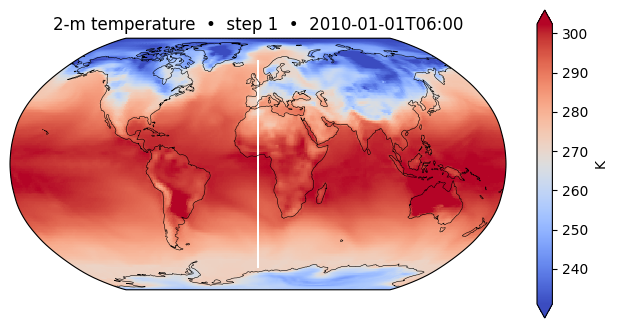

In [102]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np

def plot_t2m(ds, t_idx=0, figsize=(8, 4)):
    da = ds["2m_temperature"].isel(batch=0)

    #rechunk time as single item, interpolate missing slices
    da = (
        da.chunk({"time": -1})
          .interpolate_na("time", method="linear", fill_value="extrapolate")
    )
    da_map = da.isel(time=t_idx).compute()

    fig = plt.figure(figsize=figsize)
    ax  = fig.add_subplot(111, projection=ccrs.Robinson())
    da_map.plot(
        ax=ax,
        transform=ccrs.PlateCarree(),
        cmap="coolwarm",
        robust=True,
        cbar_kwargs={"label": "K"},
    )
    ax.coastlines(linewidth=0.4)
    ts = np.datetime_as_string(ds.time.values[t_idx], unit="m")
    ax.set_title(f"2-m temperature  •  step {t_idx}  •  {ts}")
    plt.show()
plot_t2m(example_batch, t_idx=1)


/tmp/ipython-input-105-4208606544.py:85: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


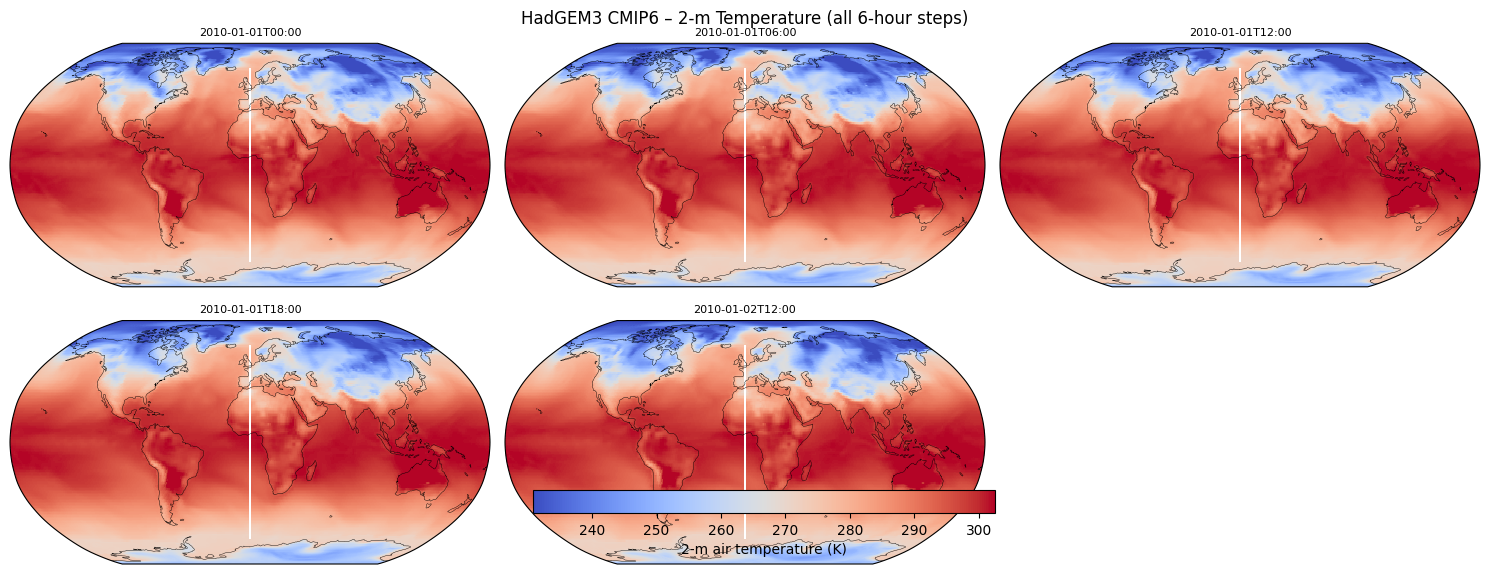

In [105]:
import math
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

def plot_t2m_all(ds: xr.Dataset,
                 max_cols: int = 3,
                 figsize_per_map=(5, 3)):
    da = (
        ds["2m_temperature"]
          .isel(batch=0)
          .chunk({"time": -1})
          .interpolate_na("time",
                          method="linear",
                          fill_value="extrapolate")
          .load()
    )

    n_t     = da.sizes["time"]
    n_cols  = min(n_t, max_cols)
    n_rows  = math.ceil(n_t / n_cols)
    fig_w   = n_cols * figsize_per_map[0]
    fig_h   = n_rows * figsize_per_map[1]

    fig, axes = plt.subplots(
        n_rows, n_cols,
        subplot_kw=dict(projection=ccrs.Robinson()),
        figsize=(fig_w, fig_h),
        squeeze=False
    )

    first_mappable = None

    for idx in range(n_t):
        r, c = divmod(idx, n_cols)
        ax   = axes[r][c]

        mappable = da.isel(time=idx).plot(
            ax=ax,
            transform=ccrs.PlateCarree(),
            cmap="coolwarm",
            robust=True,
            add_colorbar=False,
        )

        if first_mappable is None:
            first_mappable = mappable

        ts = np.datetime_as_string(ds.time.values[idx], unit="m")
        ax.set_title(ts, fontsize=8)
        ax.coastlines(linewidth=0.3)

    for idx in range(n_t, n_rows * n_cols):
        r, c = divmod(idx, n_cols)
        axes[r][c].set_visible(False)
    fig.colorbar(
        first_mappable,
        ax=axes,
        orientation="horizontal",
        fraction=0.05,
        pad=0.04,
        label="2-m air temperature (K)"
    )

    fig.suptitle("HadGEM3 CMIP6 – 2-m Temperature (all 6-hour steps)",
                 y=0.95)
    plt.tight_layout()
    plt.show()
plot_t2m_all(example_batch)